In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取所需的已经处理好的数据档案
2015 和 2016 年度，美国运输局审查的赔偿申请资料。

In [438]:
df15 = pd.read_csv('./assets/claimns_2015.csv')
df16 = pd.read_csv('./assets/claimns_2016.csv')

In [439]:
df15.drop( columns = ['Unnamed: 0'], axis = 1, inplace = True)
df16.drop( columns = ['Unnamed: 0'], axis = 1, inplace = True)

In [440]:
def find_year(x):
    return x.year

# 赔偿申请的种类
每一年 TSA 都会收到大量的赔偿申请，它们一般可以分为以下几种：
1. Passenger Property Los: 乘客的财物丢失。
2. Property Damage: 乘客的财物损坏，比如行李箱被工作人员粗暴对待而导致的损失。
3. Complaint: 投诉，一般是因为不可控原因遭受的损失，比如飞机晚点等。
4. Personal Injury: 乘客的病痛赔偿，比如因为机场地滑而跌倒等。
5. Employee Loss (MPCECA): 政府公务员或者军人的赔偿。比如公务员带着装有公务文件的行李坐飞机，行李丢了，给当地的工作带来的损失。
6. Moter Vehicle: 车辆的赔偿。一般为机场大巴或其他机场运输工具在使用过程中遭受的损坏。
7. '-': 其他或者未知。估计是没有填写这一栏，亦或数据没有被保存。
接下来，我们可以用柱形图来显示每一个赔偿类型每年收到的投诉。

In [441]:
df16['Claim Type'] = df16['Claim Type'].str.replace('^Property Loss$', 'Passenger Property Loss')
df16['Claim Type'] = df16['Claim Type'].str.replace('^Missed Flight$', 'Complaint')

In [442]:
# clean the date, convert them to datetime
df16['Incident Date'] = df16['Incident Date'].str.replace('\d+\:\d{2}', '', regex = True)
df16['Incident Date'] = df16['Incident Date'].str.replace('\:\d{2}', '', regex = True)
df16['Date Received'] = df16['Date Received'].str.replace(' \d{2}\:\d{2}\:\d{2}', '', regex = True)

df16['Incident Date'] = pd.to_datetime(df16['Incident Date'])
df16['Date Received'] = pd.to_datetime(df16['Date Received'], format = '%Y-%m-%d')
df15['Date Received'] = pd.to_datetime(df15['Date Received'], format = '%Y-%m-%d')
df15['Incident D'] = pd.to_datetime(df15['Incident D'], format = '%Y-%m-%d')

In [443]:
# find the incident year
claim_15 = df15.copy()
claim_16 = df16.copy()

# filter out the incident year which is not recent
claim_15 = claim_15[ claim_15['Incident D'].apply(find_year) == 2015]
claim_16 = claim_16[ claim_16['Incident Date'].apply(find_year) == 2016]

In [444]:
# 用 groupby 分类之后，计算每一个 group 的数目。
claim_2015 = claim_15.groupby('Claim Type').count()
claim_2015 = claim_2015.iloc[:, [0, 1]]
claim_2016 = claim_16.groupby('Claim Type').count()
claim_2016 = claim_2016.iloc[:, [0, 1]]

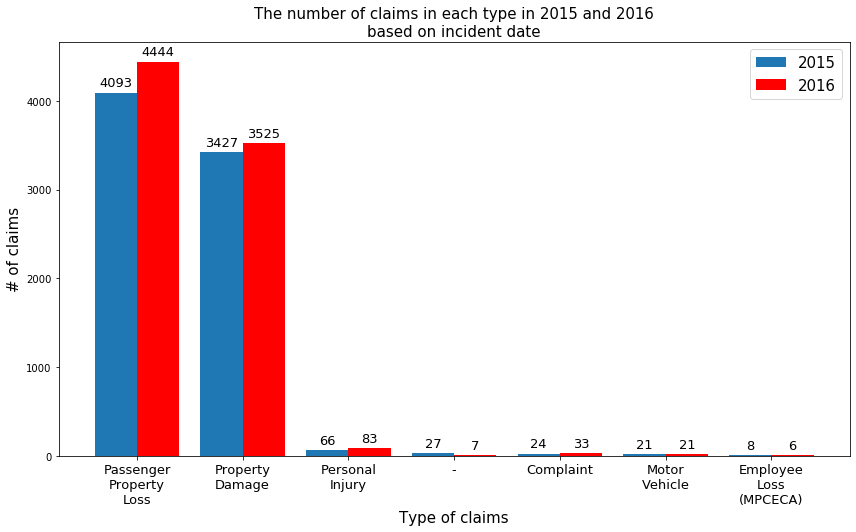

In [445]:
# define the number of types, set an array
x = list(range(len(claim_2015)))
x = np.asarray(x)

# sort counts by values
claim_2015.sort_values( by = ['Claim Number'], inplace = True, ascending=False)

fig, ax = plt.subplots( figsize = (12, 7.5) )
width = 0.4

count_15 = []
count_16 = []
types = []

for name in list(claim_2015.index):
    count_15.append( int(claim_2015.loc[name, 'Claim Number']) )
    count_16.append( int(claim_2016.loc[name, 'Claim Number']) )
    types.append(name.replace(' ', '\n'))
    
rect1 = ax.bar( x - width/2, count_15, label = '2015', width = width)
rect2 = ax.bar(x + width/2, count_16, label = '2016', width = width, color = 'red')
ax.set_xticks(x)
ax.set_xticklabels(types, fontsize = 13)
ax.set_xlabel('Type of claims', fontsize = 15)
ax.set_ylabel('# of claims', fontsize = 15)
ax.legend(fontsize = 15)
ax.set_title('The number of claims in each type in 2015 and 2016\nbased on incident date', fontsize = 15)

def autolabel(rects, fs = 13):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xycoords = 'data',
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset pixels",
                    ha='center', va='bottom', fontsize = fs)

autolabel(rect1)
autolabel(rect2)

fig.tight_layout()

plt.show()

可以看到，大部分的赔偿申请都集中在乘客的行李损失和损坏上面了。并且在绝大部分申请赔偿的类型中，2016年的数字普遍比2015年的要大一些。可能的原因为：
1. 机场的服务有下降
2. 每年的遊客數量增加導致的投訴案件增多
二个原因是非常有可能的。无论如何，2015年和2016年数据的总体趋势是相同的，乘客的财物损失和损害占了绝大多数。接下来我们可以考虑分析一下在已经或者批核( Settle, Approve in full) 的 claims，它们每一单的金额分布是怎样的呢？

# 理赔金额的统计分布
接下来我们要关注的是赔偿申请金额的分布趋势。在处理结果 ( Disposition ) 里，一共有四大类：1. 拒绝 ( Deny ) 2. 接受并全额赔偿 ( Approve in full ) 3. 同意 ( Settle, 部分金额赔偿，比如行李的话，有一个折旧价。) 4. 未知 ( -, 数据丢失或者其他原因导致处理结果不可知。) 
在这里面，只有2和3的数据给出了具体的金额。所以我们首先要把这对应这两个处理结果的数据抽离出来，再进行分析。

In [446]:
amount_15 = df15[ (df15['Disposition'] == 'Settle') | (df15['Disposition'] == 'Approve in Full')]
amount_16 = df16[ (df16['Disposition'] == 'Settle') | (df16['Disposition'] == 'Approve in Full')]

amount_15 = amount_15[amount_15['Incident D'].apply(find_year) == 2015]
amount_16 = amount_16[amount_16['Incident Date'].apply(find_year) == 2016]

發現了有趣的信息。2016年批准的賠償單數竟然只有2015年的六成，這是為何呢？

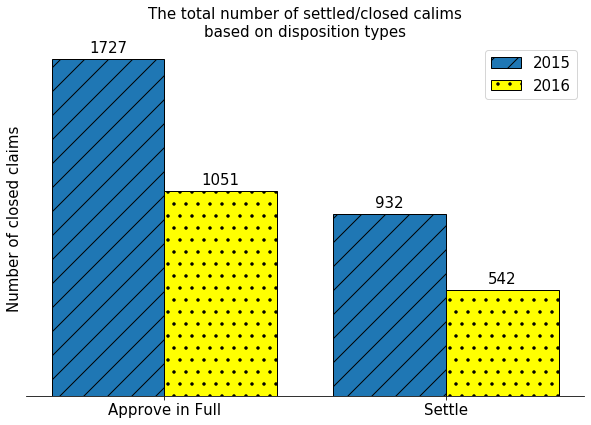

In [447]:
count_15 = amount_15.groupby('Disposition').count()[['Close Amount']]
count_16 = amount_16.groupby('Disposition').count()[['Close Amount']]

x = np.asarray([0,1])
fig, ax = plt.subplots( figsize = (10, 6.5) )
width = 0.4

rec_15 = ax.bar( x - width/2, count_15.iloc[:, 0], label = '2015', width = width, hatch= '/', edgecolor = 'k')
rec_16 = ax.bar(x + width/2, count_16.iloc[:, 0], label = '2016', width = width, color = 'yellow', hatch = '.',  edgecolor = 'k')

ax.set_xticks(x)
ax.set_xticklabels( list(count_15.index), fontsize = 15)
ax.set_ylabel('Number of closed claims', fontsize = 15)

ax.set_yticks([])
ax.get_children()[4].set_visible(False)
ax.get_children()[5].set_visible(False)
ax.get_children()[7].set_visible(False)

autolabel(rec_15, 15)
autolabel(rec_16, 15)
ax.legend(fontsize = 15)

ax.set_title('The total number of settled/closed calims\nbased on disposition types', fontsize = 15)
plt.show()

 從上圖可以看到，TSA 的 Settle Claims 在2016年比2015年整整下降了差不多40%。在實際申報數并沒有任何明顯下降的情況之下，這個現象值得我們分析。可惜我搜索了網頁，仍然無法得到答案。我猜想的情況是，也許我們上清除數據的時候清除了部分數據。亦或2016年度 TSA 的處理速度變慢了，很多申報還在處理。在網上可以查到，TSA 2016年度的賠償申報中，Settle 的金額平均數為260，而 Approve in Full 的平均金額為 135。如果我們并沒有在處理數據的時候發生大的錯誤，用我們的數據得出的結果應該是差不多的。

In [458]:
mean_a_16 = round(np.mean(amount_16[ amount_16['Disposition'] == 'Approve in Full']['Close Amount'].astype(np.float)))
mean_s_16 = round(np.mean(amount_16[ amount_16['Disposition'] == 'Settle']['Close Amount'].astype(np.float)))

print('In 2016, cases that were settled averaged a payout of ${0}. Those that were approved in \
full averaged an amount of ${1}.'.format(mean_s_16, mean_a_16))

In 2016, cases that were settled averaged a payout of $261.0. Those that were approved in full averaged an amount of $139.0.


從上面的計算中我們可以看到，我們的計算結果和官方數據給出的差別不大。所以我們并沒有在處理數據的時候犯下大的錯誤。那麼，另外一個假設就是 TSA 在2016年辦事效率變得低下。不過這個需要更多的工作進行查證，我們先放到一邊吧。

## 使用Violin Plot來展示統計分佈

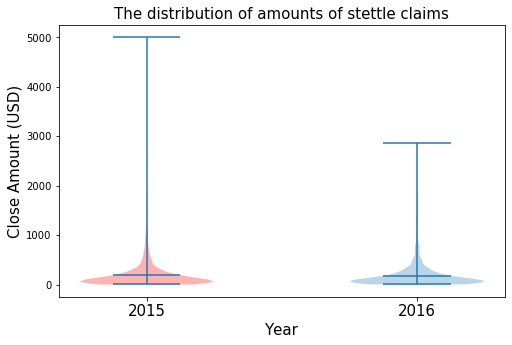

In [449]:
ca_15 = list(amount_15['Close Amount'].astype(np.float))
ca_16 = list(amount_16['Close Amount'].astype(np.float))

fig, ax = plt.subplots(figsize = (8, 5))

ax.violinplot(dataset = [ca_15, ca_16], positions = x, showmeans = True)
ax.get_children()[0].set_facecolor('red')
ax.set_xticks(x)
ax.set_xticklabels(['2015', '2016'], fontsize = 15)
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Close Amount (USD)', fontsize = 15)
ax.set_title('The distribution of amounts of stettle claims', fontsize = 15)

plt.show()

從上面的圖可以看到，可視化的效果差強人意，因為所得的分佈 Skweness 有極大的正值，大部分數據集中在左側（小於平均值,即是圖中中間那條橫線），導致圖形很不對稱。這個時候，我們可以使用 $log_{10}$ 來轉換數據。關於 Data Transformation 的更多資訊，請點擊[這裡](https://en.wikipedia.org/wiki/Data_transformation_(statistics)).

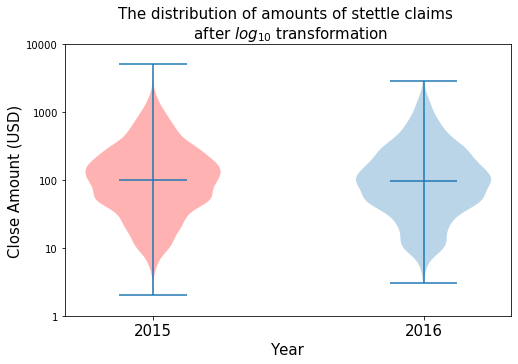

In [450]:
log_ca_15 = np.log10(ca_15)
log_ca_16 = np.log10(ca_16)

fig, ax = plt.subplots(figsize = (8, 5))

ax.violinplot(dataset = [log_ca_15, log_ca_16], positions = x, showmedians = True)

# change the color of the first violin
ax.get_children()[0].set_facecolor('red')

# set up x-axis
ax.set_xticks(x)
ax.set_xticklabels(['2015', '2016'], fontsize = 15)
ax.set_xlabel('Year', fontsize = 15)

# set up y-axis
ax.set_ylabel('Close Amount (USD)', fontsize = 15)
ax.set_title('The distribution of amounts of stettle claims \n after $log_{10}$ transformation', fontsize = 15)
ax.set_yticks([0, 1, 2, 3, 4])
scale = ax.get_yticks()
ax.set_yticklabels(np.round(10**scale))


plt.show()

可以看到，經過轉換之後，所繪出的圖形更具有可讀性。必須注意的是，左邊Y軸的數值，並不是線性變化的。而且看起來兩年的平均值相差不大，看來TSA似乎有制定一個賠償數值的標準。

# 年度最差機場
在申請賠償時，需要填寫發生事故所在的機場編號。根據這個信息，我們就可以知道哪個機場造成了本年度最多的賠償。因為TSA 批准的賠償是有一定標準的，如果乘客自己需要承擔很大一部分責任的話，TSA一般不會批准旅客提交的賠償申請。我們可以通過計算該年度每個機場事故賠償的總額，來找出年度最差機場。首先我們看看2015年的年度排名吧。

In [451]:
# find the top 10 airports with worst performance
airport_amount = amount_15.copy()
airport_amount['Close Amount'] = airport_amount['Close Amount'].astype(np.float)
group_2015 = airport_amount.groupby('Airport Code').sum().reset_index()
top_10_2015 = list(group_2015.sort_values( by = ['Close Amount'], ascending = False).iloc[:10, 0])

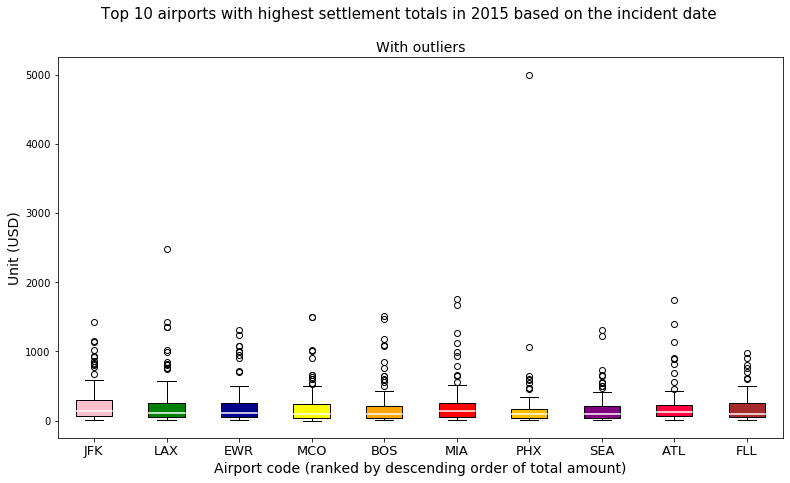

In [452]:
airport_2015 = []
x = list( range(10) )

colors = ['pink', 'green', '#00008b', 'yellow', 'orange', 'red', '#ffbf00', 'purple', '#ff0040', 'brown']

for code in top_10_2015:
    airport_2015.append( airport_amount[ airport_amount['Airport Code'] == code]['Close Amount'])
    
# set up median properties
medianprops = dict(linestyle='-', linewidth=1.5, color='white')
    
fig, ax = plt.subplots( figsize = (13, 7))
bp15 = ax.boxplot(airport_2015, positions = x, patch_artist=True, medianprops=medianprops)

# set colors
for x in range(len(bp15['boxes'])):
    bp15['boxes'][x].set_facecolor( colors[x])
    bp15['boxes'][x].set_edgecolor( 'k' )
    bp15['boxes'][x].set_linewidth(1)

ax.set_xticklabels( top_10_2015, fontsize = 13 )
ax.set_title('With outliers', fontsize  = 14)
ax.set_ylabel('Unit (USD)', fontsize = 14)
ax.set_xlabel('Airport code (ranked by descending order of total amount)', fontsize = 14)

fig.suptitle('Top 10 airports with highest settlement totals in 2015 based on the incident date', fontsize = 15)
plt.show()

上图的效果并不是特别好，原因就是大量存在的 Outliers （异常值）。如果去掉异常值，我们应该可以更方便的比较数据的中位数了。

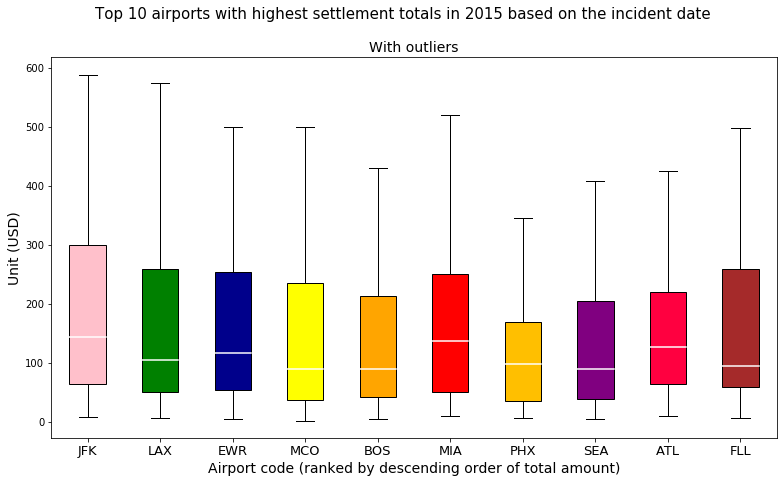

In [453]:
airport_2015 = []
x = list( range(10) )

colors = ['pink', 'green', '#00008b', 'yellow', 'orange', 'red', '#ffbf00', 'purple', '#ff0040', 'brown']

for code in top_10_2015:
    airport_2015.append( airport_amount[ airport_amount['Airport Code'] == code]['Close Amount'])
    
# set up median properties
medianprops = dict(linestyle='-', linewidth=1.5, color='white')
    
fig, ax = plt.subplots( figsize = (13, 7))
bp15 = ax.boxplot(airport_2015, positions = x, patch_artist=True, medianprops=medianprops, showfliers = False)

# set colors
for x in range(len(bp15['boxes'])):
    bp15['boxes'][x].set_facecolor( colors[x])
    bp15['boxes'][x].set_edgecolor( 'k' )
    bp15['boxes'][x].set_linewidth(1)

ax.set_xticklabels( top_10_2015, fontsize = 13 )
ax.set_title('With outliers', fontsize  = 14)
ax.set_ylabel('Unit (USD)', fontsize = 14)
ax.set_xlabel('Airport code (ranked by descending order of total amount)', fontsize = 14)

fig.suptitle('Top 10 airports with highest settlement totals in 2015 based on the incident date', fontsize = 15)
plt.show()

从上的图示可以看到，JFK 赔偿的总数在第一位，为2015年榜首。接下来我们把2016年的数据也加上，一起比较，看看哪个机场可以连续两年取得佳绩。

In [454]:
# find the top 10 in 2016
airport16_amount = amount_16.copy()
airport16_amount['Close Amount'] = airport16_amount['Close Amount'].astype(np.float)
group_2016 = airport16_amount.groupby('Airport Code').sum().reset_index()
top_10_2016 = list(group_2016.sort_values( by = ['Close Amount'], ascending = False).iloc[:10, 0])

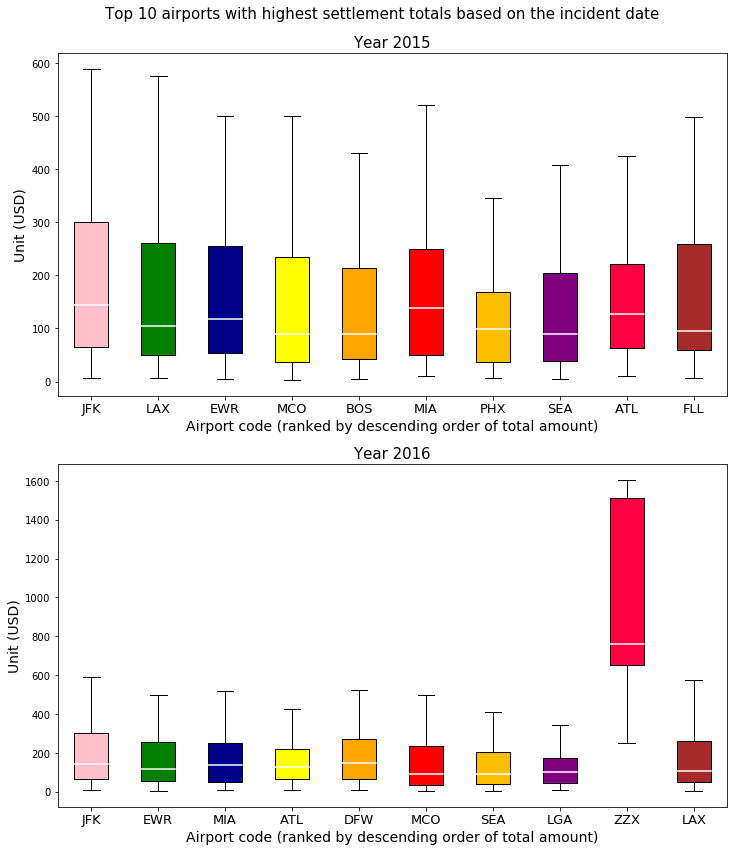

In [455]:
airport_2016 = []
x = list( range(10) )

for code in top_10_2016:
    airport_2016.append( airport_amount[ airport_amount['Airport Code'] == code]['Close Amount'])
    
# set up median properties
medianprops = dict(linestyle='-', linewidth=1.5, color='white')
    
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 13))
bp15 = ax1.boxplot(airport_2015, positions = x, patch_artist=True, medianprops=medianprops, showfliers = False)
bp16 = ax2.boxplot(airport_2016, positions = x, patch_artist=True, medianprops=medianprops, showfliers = False)

# set colors
for x in range(len(bp15['boxes'])):
    bp15['boxes'][x].set_facecolor( colors[x])
    bp15['boxes'][x].set_edgecolor( 'k' )
    bp15['boxes'][x].set_linewidth(1)
    bp16['boxes'][x].set_facecolor( colors[x])
    bp16['boxes'][x].set_edgecolor( 'k' )
    bp16['boxes'][x].set_linewidth(1)

ax1.set_xticklabels( top_10_2015, fontsize = 13 )
ax2.set_xticklabels( top_10_2016, fontsize = 13 )

ax1.set_title('Year 2015', fontsize  = 15)
ax2.set_title('Year 2016', fontsize  = 15)

ax1.set_ylabel('Unit (USD)', fontsize = 14)
ax2.set_ylabel('Unit (USD)', fontsize = 14)

ax1.set_xlabel('Airport code (ranked by descending order of total amount)', fontsize = 14)
ax2.set_xlabel('Airport code (ranked by descending order of total amount)', fontsize = 14)

fig.subplots_adjust(top=0.93)
fig.suptitle('Top 10 airports with highest settlement totals based on the incident date', fontsize = 15)
plt.show()

结果不出意料，大部分在2015年处于赔偿总额榜首的机场，在2016年度也是榜上有名的。特别值得一提的是 JKF（John F. Kennedy International Airport），是纽约最大的国际机场。也许是因为往来的游客比较多，所以发生的事故也较多吧。另外全世界最繁忙的机场 ATL（Hartsfield-Jackson Atlanta International Airport）也是连续两年上榜的。另外2016年还有一个中位数远远高于其他机场的 ZZX，实际上它并不是机场，而是所有机场机动车辆的赔偿申请（Non TSA Airport (motor vehicle)）。车辆发动事故时产生的赔偿肯定比大部分的行李损坏产生的赔偿要多吧，这也就是为什么中位数值很大的原因。综合来说，连续两年都处在赔偿总额龙虎榜十大的机场有：
1. JFK: John F. Kennedy International Airport （纽约）
2. EWR: Newark Liberty International Airport （新泽西）
3. MIA: Miami International Airport （迈阿密）
4. MCO: Orlando International Airport （奥兰多）
5. SEA: Seattle-Tacoma International Airport （西雅图）
6. ATL: Hartsfield-Jackson Atlanta International Airport （亚特兰大）
7. LAX: Los Angeles International Airport （洛杉矶）

# TSA 机场单月赔偿申请统计
最后，我们来看看每个月的机场申请赔偿总数（批准的，拒绝的，以及处理仍未知的）。

In [456]:
# copy the data
monthly_15 = df15.copy()
monthly_16 = df16.copy()

monthly_15 = monthly_15[ monthly_15['Date Received'].apply(find_year) == 2015]
monthly_16 = monthly_16[ monthly_16['Date Received'].apply(find_year) == 2016]

# contruct a column of months
monthly_15['month'] = monthly_15['Date Received'].apply( lambda x: x.month)
monthly_16['month'] = monthly_16['Date Received'].apply( lambda x: x.month)

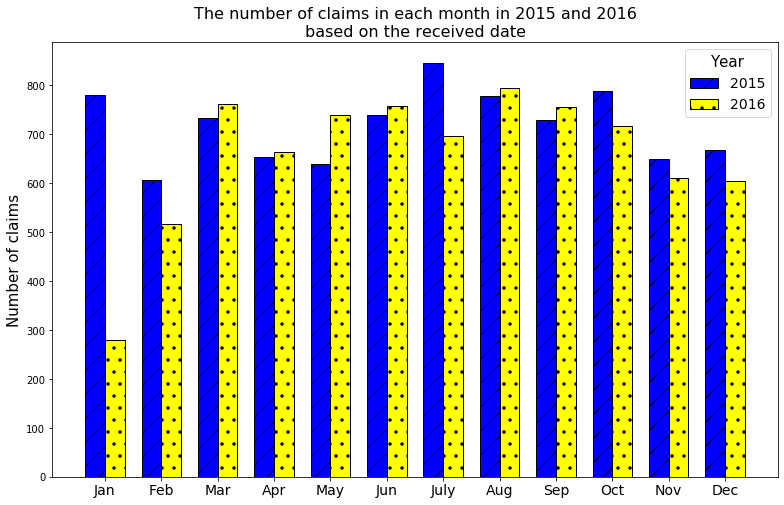

In [457]:
# starting plot
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

group_m_15 = monthly_15.groupby('month').count()['Close Amount']
group_m_16 = monthly_16.groupby('month').count()['Close Amount']

# figure
x =   np.arange(1, 13)
width = 0.35

fig, ax = plt.subplots( figsize = (13, 8))

ax.bar( x - width/2, group_m_15, color = 'blue', hatch = '/',  edgecolor = 'k', label = '2015', width = width)
ax.bar( x + width/2, group_m_16, color = 'yellow', hatch = '.', edgecolor = 'k', label = '2016', width = width)

ax.set_ylabel('Number of claims', fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(months, fontsize = 14)
ax.legend(title = 'Year', fontsize = 14, title_fontsize = 15)
ax.set_title('The number of claims in each month in 2015 and 2016\nbased on the received date', fontsize = 16)

plt.show()

非常有趣的结果，两个年度一月份的对比有些异常，2016年的 Claims 数大大小于2015年同月份的数据。因为掌握的信息有限，其原因就不得而知了。